In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
path_train = 'classification_vg/Bacterial_identification_DNA_oligomers/data/train.csv'
df = pd.read_csv(path_train, sep  = ',', index_col = 0)

In [6]:
X = df.drop(columns = ['target'])

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(df['target'])

print(f"The dimensions of my entire DataFrame are: {X.shape}")
print(f"The dimension of my vector target is: {Y.shape}")

nul = X.isnull().sum()[X.isnull().sum() != 0]
non_numeric = X.dtypes[X.dtypes != 'float64']

print(f"The DataFrame has {len(nul)} nul values")
print(f"The DataFrame has {len(non_numeric)} non numeric columns")

The dimensions of my entire DataFrame are: (200000, 286)
The dimension of my vector target is: (200000,)
The DataFrame has 0 nul values
The DataFrame has 0 non numeric columns


### Separating variables using RandomForestClassifier criterion of importance

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def selected_features(X,Y,p):
    model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs= -1)
    model.fit(X, Y)
    
    feature_importances = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    cumulative_importance = importance_df['Importance'].cumsum()
    selected_features = importance_df[cumulative_importance <= p]['Feature'].values
    
    return X[selected_features]

def XGB_model(X,Y,p):
    X_selected = selected_features(X,Y,p)
    X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.3, random_state=42)

    modelXGB = XGBClassifier(n_jobs=-1)  
    modelXGB.fit(X_train, y_train)
    
    y_pred_XGB = modelXGB.predict(X_test)
    
    return accuracy_score(y_test, y_pred_XGB), classification_report(y_test, y_pred_XGB, output_dict = True)

In [8]:
acc, report = XGB_model(X,Y,0.25)
print(acc)
print(pd.DataFrame(report))

0.9127166666666666
                     0            1            2            3            4  \
precision     0.946447     0.878975     0.832523     0.945062     0.932240   
recall        0.921994     0.933290     0.858409     0.931040     0.938616   
f1-score      0.934060     0.905318     0.845267     0.937999     0.935417   
support    6038.000000  6101.000000  5982.000000  5931.000000  5995.000000   

                     5            6            7            8            9  \
precision     0.976060     0.964664     0.924308     0.855248     0.881157   
recall        0.970748     0.948858     0.900754     0.870883     0.853520   
f1-score      0.973397     0.956696     0.912379     0.862995     0.867119   
support    5880.000000  6042.000000  5965.000000  6072.000000  5994.000000   

           accuracy     macro avg  weighted avg  
precision  0.912717      0.913668      0.913455  
recall     0.912717      0.912811      0.912717  
f1-score   0.912717      0.913065      0.912910  

In [9]:
thresholds = [1, 0.75, 0.6, 0.4, 0.3, 0.2, 0.1]
accuracies = []
reports = []

for threshold in thresholds:
    acc, report = XGB_model(X,Y, threshold)
    accuracies.append(acc)
    reports.append(report)

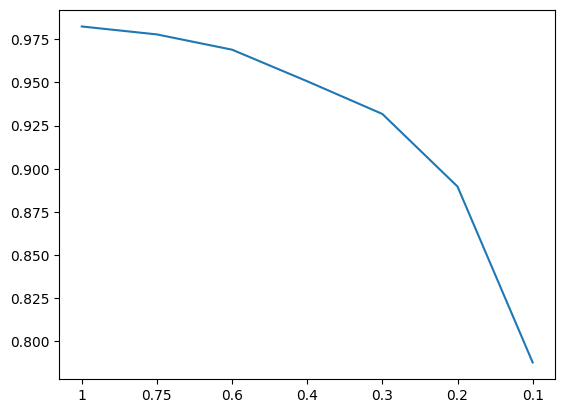

In [10]:
for i in range(len(thresholds)):
    thresholds[i] = str(thresholds[i])

plt.plot(thresholds, accuracies)
plt.show()

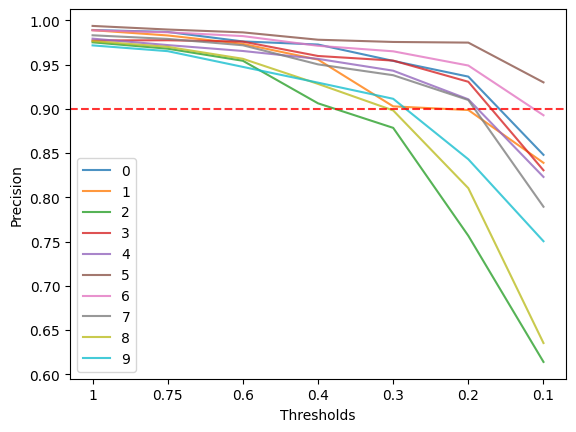

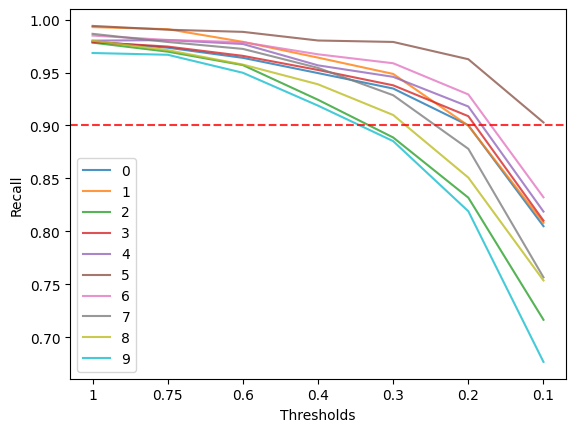

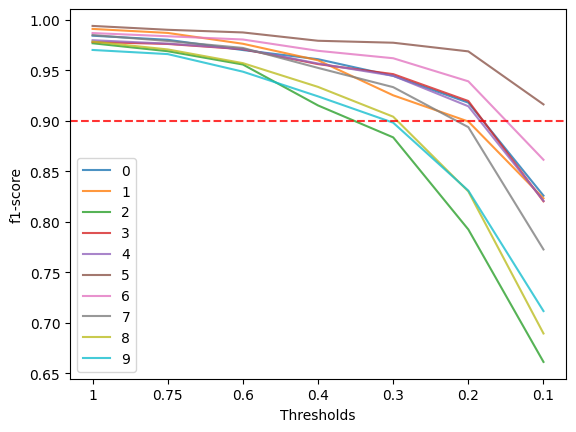

In [11]:
def plot_metric(metric_name, ylabel):
    for number in range(10):
        metric_values = [report[str(number)][metric_name] for report in reports]
        plt.plot(thresholds, metric_values, label=number, alpha=0.8)
    plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.8)
    plt.xlabel('Thresholds')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_metric('precision', 'Precision')
plot_metric('recall', 'Recall')
plot_metric('f1-score', 'f1-score')
